In [1]:
from PIL import Image, ImageDraw
from ultralytics import YOLO
import json
import numpy as np
import matplotlib.path as mpltPath
import csv
import matplotlib.pyplot as plt
import sys
import matplotlib.colors as mcolors
import cv2
import statistics
import math
import os
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point
from matplotlib.path import Path
import pandas as pd


image 1/1 S:\Phys\FIV925 XSection\Datasets\Creed\toViz\nonGABA clusters_F1.ome0.bmp: 576x480 971 Nucs, 295.7ms
Speed: 1.6ms preprocess, 295.7ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 480)
image  0
image name:  nonGABA clusters_F1.ome0.bmp
contains masks?  False
classes:  {0: 'Nuc'}
box intensities:  [array([12306., 11294., 10600., 16208., 17490.,   577.,  9887., 10787., 10676., 12326.,  7418.,  5918.,  2858.]), array([ 5273.,  3850.,  4629.,  4279.,  4663.,    98.,  2047.,  5313.,  8499., 16802.,  4563.,  4091.,  2312.]), array([ 7490.,  6234.,  7453.,  8108.,  9469.,   158.,  3549.,  8897., 17606., 33680.,  5654.,  8010.,  2255.]), array([ 6173.,  6124.,  8096., 14383., 15869.,   154.,  4777.,  9502., 13590., 13897.,  6850.,  6524.,  2602.]), array([5914., 6034., 6178., 4613., 5639.,  207., 4538., 5036., 4640., 5891., 5586., 3786., 1436.]), array([10826.,  9826., 13128., 14525., 13736.,   410.,  6113.,  8465., 13341., 23688., 10493.,  8705., 10976.]), array([ 773

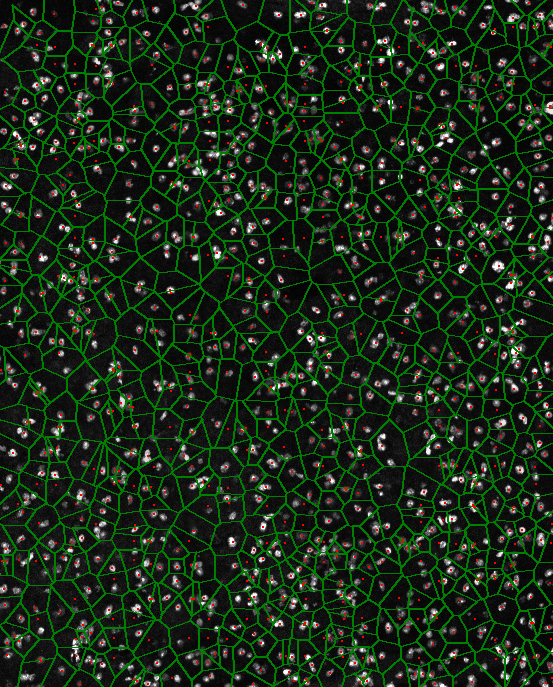

In [23]:
model_path = r"S:\Phys\FIV925 XSection\Datasets\Creed\01a\YO 553 0328 MAXI\map75=0296662 yolov9c  idx=1 ep=8 btch=16 rnd=4717152\weights\best.pt"
val_data = r"S:\Phys\FIV925 XSection\Datasets\Creed\toViz"
folder_path = r"S:\Phys\FIV925 XSection\Datasets\Creed\Aligned"

files = os.listdir(val_data)

model = YOLO(model_path)
predictions = model.predict(val_data, show=False, max_det=1000)

def polygon_area(coords):
    """
    Calculate the area of a polygon given its vertices using numpy.
    :param coords: A numpy array of shape (n, 2), where n is the number of vertices.
    :return: The area of the polygon.
    """
    x = coords[:, 0]
    y = coords[:, 1]
    i = np.arange(len(x))
    # 'shoelace' formula
    # return 0.5*np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))
    return np.abs(np.sum(x[i-1]*y[i]-x[i]*y[i-1])*0.5)

def find_parents(classes, image):
    class0_indices = np.where(classes == 0)[0]
    class1_indices = np.where(classes == 1)[0]
    
    class1_centers = image.boxes.xywh[class1_indices]
    class0_centers = image.boxes.xywh[class0_indices]
    
    class1_parents = []
    for class1_coord in class1_centers.numpy():
                # print("the class1 instance: ", class1_coord)
                
                droplet_x = class1_coord[0]
                droplet_y = class1_coord[1]
                # print("droplet x, y coords: ", droplet_x, droplet_y)
                min_distance_from_cells = math.inf
                parent_cell_index = 0
                for i, class0_coord in enumerate(class0_centers.numpy()):
                    # print("the class0 instance: ", class0_coord)
                    
                    cell_x = class0_coord[0]
                    cell_y = class0_coord[1]
                    # print("cell x, y coords: ", cell_x, cell_y)
                    point1 = np.array((droplet_x, droplet_y))
                    point2 = np.array((cell_x, cell_y))
                    dist = np.linalg.norm(point1 - point2)
                    # print("dist from class0 instance: ", dist)
                    if dist < min_distance_from_cells:
                        min_distance_from_cells = dist
                        parent_cell_index = i
                        
                # print("parent cell index: ", parent_cell_index)        
                class1_parents.append(class0_indices[parent_cell_index])
    return class1_parents

def find_mask_intensities(img_mask_coords, image_path):
    image_array = np.array(Image.open(image_path))
    pixel_intensity_data = []
    for mask_outline in range(len(img_mask_coords)):
        vertices = img_mask_coords[mask_outline]

        
        # Assuming image_array is a 2D numpy array for a grayscale image
        # For a color image, you need to decide how to handle the color channels

        # Create a mesh grid of coordinate values
        xx, yy = np.meshgrid(np.arange(image_array.shape[1]), np.arange(image_array.shape[0]))

        # Flatten the grid arrays
        x_flat = xx.flatten()
        y_flat = yy.flatten()

        # Create a list of (x, y) points from the flattened grid
        class1_points = np.vstack((x_flat, y_flat)).T

        # Create a path object from the vertices
        polygon_path = mpltPath.Path(vertices)

        # Use the path object to create a mask
        inside_polygon = polygon_path.contains_points(class1_points)

        # Reshape the mask back to the image shape
        mask = inside_polygon.reshape(xx.shape)

        # Apply the mask to select pixels within the polygon
        # selected_pixels = image_array[mask]

        # Sum the intensities of the selected pixels
        # sum_of_intensities = np.sum(selected_pixels)

        # print("Sum of pixel intensities in the polygonal region:", sum_of_intensities)
        # Initialize an array to hold the sum of intensities for each channel
        sum_of_intensities_per_channel = np.zeros(image_array.shape[2])

        # Iterate over each channel
        for i in range(image_array.shape[2]):
            # Apply the mask to the current channel and sum the intensities
            selected_pixels = image_array[:, :, i][mask]
            sum_of_intensities_per_channel[i] = np.sum(selected_pixels)

        # print("Sum of pixel intensities in the polygonal region for each channel:", sum_of_intensities_per_channel)
        pixel_intensity_data.append(sum_of_intensities_per_channel)
        
    return pixel_intensity_data

def find_box_intensities(img_data, image_path):
    img_box_centers = img_data.boxes.xywh.numpy()
    image_array = np.array(Image.open(image_path))
    box_intensity_data = []
    for box_instance in range(len(img_box_centers)):
        bbox_xywh = img_box_centers[box_instance]
        bbox_corners = [[bbox_xywh[0] - bbox_xywh[2], bbox_xywh[1] + bbox_xywh[3]],[bbox_xywh[0] + bbox_xywh[2], bbox_xywh[1] + bbox_xywh[3]]
                    , [bbox_xywh[0] + bbox_xywh[2], bbox_xywh[1] - bbox_xywh[3]], [bbox_xywh[0] - bbox_xywh[2], bbox_xywh[1] - bbox_xywh[3]]]
        vertices = bbox_corners

        
        # Assuming image_array is a 2D numpy array for a grayscale image
        # For a color image, you need to decide how to handle the color channels

        # Create a mesh grid of coordinate values
        xx, yy = np.meshgrid(np.arange(image_array.shape[1]), np.arange(image_array.shape[0]))

        # Flatten the grid arrays
        x_flat = xx.flatten()
        y_flat = yy.flatten()

        # Create a list of (x, y) points from the flattened grid
        class1_points = np.vstack((x_flat, y_flat)).T

        # Create a path object from the vertices
        polygon_path = mpltPath.Path(vertices)

        # Use the path object to create a mask
        inside_polygon = polygon_path.contains_points(class1_points)

        # Reshape the mask back to the image shape
        mask = inside_polygon.reshape(xx.shape)

        # Apply the mask to select pixels within the polygon
        # selected_pixels = image_array[mask]

        # Sum the intensities of the selected pixels
        # sum_of_intensities = np.sum(selected_pixels)

        # print("Sum of pixel intensities in the polygonal region:", sum_of_intensities)
        # Initialize an array to hold the sum of intensities for each channel
        sum_of_intensities_per_channel = np.zeros(image_array.shape[2])

        # Iterate over each channel
        for i in range(image_array.shape[2]):
            # Apply the mask to the current channel and sum the intensities
            selected_pixels = image_array[:, :, i][mask]
            sum_of_intensities_per_channel[i] = np.sum(selected_pixels)

        # print("Sum of pixel intensities in the polygonal region for each channel:", sum_of_intensities_per_channel)
        box_intensity_data.append(sum_of_intensities_per_channel)
        
    return box_intensity_data 

def create_multichannel_array(folder_path):
    image_arrays = []
    image_names = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg','.bmp','.tif')):
                file_path = os.path.join(root, file)
                t_img = Image.open(file_path).convert('L')  # Convert to grayscale if not already
                t_arr = np.array(t_img)
                if t_arr.ndim == 2:  # Ensure the image is grayscale
                    image_arrays.append(t_arr)
                    image_names.append(file)
    
    if not image_arrays:
        return None  # Or raise an exception if you prefer

    # Stack the arrays along a new axis to create a multi-channel array
    multi_channel_array = np.stack(image_arrays, axis=-1)
    return multi_channel_array, image_names

def find_box_intensities_m(img_data, folder_path):
    img_box_centers = img_data.boxes.xywh.numpy()
    image_array, image_names = create_multichannel_array(folder_path)
    box_intensity_data = []
    for box_instance in range(len(img_box_centers)):
        bbox_xywh = img_box_centers[box_instance]
        bbox_corners = [[bbox_xywh[0] - bbox_xywh[2], bbox_xywh[1] + bbox_xywh[3]],[bbox_xywh[0] + bbox_xywh[2], bbox_xywh[1] + bbox_xywh[3]]
                    , [bbox_xywh[0] + bbox_xywh[2], bbox_xywh[1] - bbox_xywh[3]], [bbox_xywh[0] - bbox_xywh[2], bbox_xywh[1] - bbox_xywh[3]]]
        vertices = bbox_corners

        
        # Assuming image_array is a 2D numpy array for a grayscale image
        # For a color image, you need to decide how to handle the color channels

        # Create a mesh grid of coordinate values
        xx, yy = np.meshgrid(np.arange(image_array.shape[1]), np.arange(image_array.shape[0]))

        # Flatten the grid arrays
        x_flat = xx.flatten()
        y_flat = yy.flatten()

        # Create a list of (x, y) points from the flattened grid
        class1_points = np.vstack((x_flat, y_flat)).T

        # Create a path object from the vertices
        polygon_path = mpltPath.Path(vertices)

        # Use the path object to create a mask
        inside_polygon = polygon_path.contains_points(class1_points)

        # Reshape the mask back to the image shape
        mask = inside_polygon.reshape(xx.shape)

        # Apply the mask to select pixels within the polygon
        # selected_pixels = image_array[mask]

        # Sum the intensities of the selected pixels
        # sum_of_intensities = np.sum(selected_pixels)

        # print("Sum of pixel intensities in the polygonal region:", sum_of_intensities)
        # Initialize an array to hold the sum of intensities for each channel
        sum_of_intensities_per_channel = np.zeros(image_array.shape[2])

        # Iterate over each channel
        for i in range(image_array.shape[2]):
            # Apply the mask to the current channel and sum the intensities
            selected_pixels = image_array[:, :, i][mask]
            sum_of_intensities_per_channel[i] = np.sum(selected_pixels)

        # print("Sum of pixel intensities in the polygonal region for each channel:", sum_of_intensities_per_channel)
        box_intensity_data.append(sum_of_intensities_per_channel)
        
    return box_intensity_data, image_names

header = ["FilePath", "PolyID","cls","Vertices","Number of Vertices","PolyArea","Sum Inten WV0","SumInten WV1", "SumInten WV2","BBox x","BBox y","BBox w","BBox h",
          "BBox intensity WV0", "BBox intensity WV1","BBox intensity WV2","Conf","PolySum", "PolyAvg", "PolyStDDev", "BoxSum", "BoxAvg", "BoxStDDev", "Parents"]
data = []
folder_is_channels = True

for i, image_data in enumerate(predictions):
    print("image ", i)
    print("image name: ", os.listdir(val_data)[i])
    img_box_coords = image_data.boxes.xyxy
    image_path = val_data + "\\" + os.listdir(val_data)[i]
    image_info_toexport = []
    
    # if folder_is_channels:
    #     image_array, image_names = create_multichannel_array(image_data, folder_path)
    
    contains_masks = True
    if image_data.masks == None:
        contains_masks = False
    print("contains masks? ", contains_masks)
    
    classes = image_data.names
    print("classes: ", classes)
    
    polygon_areas = []
    pixel_intensity_data = []
    if contains_masks:
        polygon_areas = [polygon_area(mask) for mask in image_data.masks.xy]
        print("polygon areas: ", polygon_areas)
        pixel_intensity_data = find_mask_intensities(image_data.masks.xy, image_path)
        print("pixel intensities: ", pixel_intensity_data)
    
    if folder_is_channels:
        box_intensity_data, image_names = find_box_intensities_m(image_data, folder_path)
    else:
        box_intensity_data = find_box_intensities(image_data, image_path)
    print("box intensities: ", box_intensity_data)
    
    print("same number of boxes as polygons? ", len(box_intensity_data) == len(pixel_intensity_data))
        
    class1_parents = []
    if len(classes) == 2:
        class1_parents = find_parents(image_data.boxes.cls.numpy(), image_data)
        print("class1 parents: ", class1_parents)
    
    for j in range(len(box_intensity_data)):
        bbox_data = predictions[i].boxes[j].xywh.numpy()
        bbox_x, bbox_y, bbox_w, bbox_h, cls = bbox_data.item(0),bbox_data.item(1),bbox_data.item(2),bbox_data.item(3),predictions[i].boxes[j].cls.numpy().item(0)
        data.append([bbox_x, bbox_y, bbox_w, bbox_h, cls])   
        
df = pd.DataFrame(data, columns=['BBox x', 'BBox y', 'BBox w', 'BBox h', 'cls'])

points= []
clss = []

# Voronoi on points of each cell
imgV = Image.open(r"S:\Phys\FIV925 XSection\Datasets\Creed\toViz\nonGABA clusters_F1.ome0.bmp").convert('RGB')
drawV = ImageDraw.Draw(imgV)
for index, row in df.iterrows():
    x, y, w, h = row["BBox x"], row["BBox y"], row["BBox w"], row["BBox h"]
    points.append((x, y))
    
    # points = np.array(points)
    if len(points) < 4:
        continue
    vor = Voronoi(points)
    
    region_paths = {}
    vertices_list = []
    for point_region_id, region_id in enumerate(vor.point_region):
        if (-1 not in vor.regions[region_id]):
            region_vertices = vor.vertices[vor.regions[region_id]]
            vertices_list.append(region_vertices.tolist())
        else: 
            vertices_list.append([])
            
df["voronoi_polygon"] = vertices_list

for simplex in vor.ridge_vertices:
    simplex = np.asarray(simplex)
    if np.all(simplex >= 0):
        start_point, end_point = vor.vertices[simplex]
        drawV.line((start_point[0], start_point[1], end_point[0], end_point[1]), fill='green', width=2)     
        
for point in points:
    # Define the size of the point to draw
    r = 0.5  # radius of the points
    left_up_point = (point[0] - r, point[1] - r)
    right_down_point = (point[0] + r, point[1] + r)
    drawV.ellipse([left_up_point, right_down_point], fill='red')    
display(imgV)


image 1/1 S:\Phys\FIV925 XSection\Datasets\Creed\toViz\nonGABA clusters_F1.ome0.bmp: 576x480 971 Nucs, 287.5ms
Speed: 1.5ms preprocess, 287.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 480)
image  0
image name:  nonGABA clusters_F1.ome0.bmp
contains masks?  False
classes:  {0: 'Nuc'}
box intensities:  [array([12306., 11294., 10600., 16208., 17490.,   577.,  9887., 10787., 10676., 12326.,  7418.,  5918.,  2858.]), array([ 5273.,  3850.,  4629.,  4279.,  4663.,    98.,  2047.,  5313.,  8499., 16802.,  4563.,  4091.,  2312.]), array([ 7490.,  6234.,  7453.,  8108.,  9469.,   158.,  3549.,  8897., 17606., 33680.,  5654.,  8010.,  2255.]), array([ 6173.,  6124.,  8096., 14383., 15869.,   154.,  4777.,  9502., 13590., 13897.,  6850.,  6524.,  2602.]), array([5914., 6034., 6178., 4613., 5639.,  207., 4538., 5036., 4640., 5891., 5586., 3786., 1436.]), array([10826.,  9826., 13128., 14525., 13736.,   410.,  6113.,  8465., 13341., 23688., 10493.,  8705., 10976.]), array([ 773

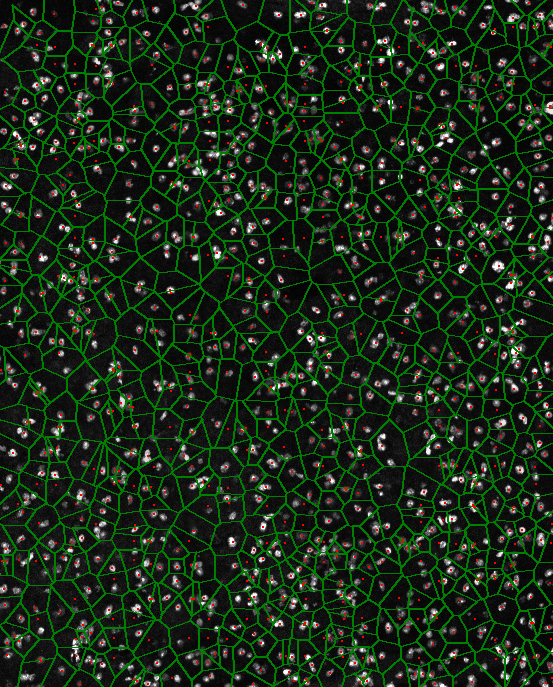

In [24]:

model_path = r"S:\Phys\FIV925 XSection\Datasets\Creed\01a\YO 553 0328 MAXI\map75=0296662 yolov9c  idx=1 ep=8 btch=16 rnd=4717152\weights\best.pt"
val_data = r"S:\Phys\FIV925 XSection\Datasets\Creed\toViz"
folder_path = r"S:\Phys\FIV925 XSection\Datasets\Creed\Aligned"

files = os.listdir(val_data)

model = YOLO(model_path)
predictions = model.predict(val_data, show=False, max_det=1000)

def polygon_area(coords):
    """
    Calculate the area of a polygon given its vertices using numpy.
    :param coords: A numpy array of shape (n, 2), where n is the number of vertices.
    :return: The area of the polygon.
    """
    x = coords[:, 0]
    y = coords[:, 1]
    i = np.arange(len(x))
    # 'shoelace' formula
    # return 0.5*np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))
    return np.abs(np.sum(x[i-1]*y[i]-x[i]*y[i-1])*0.5)

def find_parents(classes, image):
    class0_indices = np.where(classes == 0)[0]
    class1_indices = np.where(classes == 1)[0]
    
    class1_centers = image.boxes.xywh[class1_indices]
    class0_centers = image.boxes.xywh[class0_indices]
    
    class1_parents = []
    for class1_coord in class1_centers.numpy():
                # print("the class1 instance: ", class1_coord)
                
                droplet_x = class1_coord[0]
                droplet_y = class1_coord[1]
                # print("droplet x, y coords: ", droplet_x, droplet_y)
                min_distance_from_cells = math.inf
                parent_cell_index = 0
                for i, class0_coord in enumerate(class0_centers.numpy()):
                    # print("the class0 instance: ", class0_coord)
                    
                    cell_x = class0_coord[0]
                    cell_y = class0_coord[1]
                    # print("cell x, y coords: ", cell_x, cell_y)
                    point1 = np.array((droplet_x, droplet_y))
                    point2 = np.array((cell_x, cell_y))
                    dist = np.linalg.norm(point1 - point2)
                    # print("dist from class0 instance: ", dist)
                    if dist < min_distance_from_cells:
                        min_distance_from_cells = dist
                        parent_cell_index = i
                        
                # print("parent cell index: ", parent_cell_index)        
                class1_parents.append(class0_indices[parent_cell_index])
    return class1_parents

def find_mask_intensities(img_mask_coords, image_path):
    image_array = np.array(Image.open(image_path))
    pixel_intensity_data = []
    for mask_outline in range(len(img_mask_coords)):
        vertices = img_mask_coords[mask_outline]

        
        # Assuming image_array is a 2D numpy array for a grayscale image
        # For a color image, you need to decide how to handle the color channels

        # Create a mesh grid of coordinate values
        xx, yy = np.meshgrid(np.arange(image_array.shape[1]), np.arange(image_array.shape[0]))

        # Flatten the grid arrays
        x_flat = xx.flatten()
        y_flat = yy.flatten()

        # Create a list of (x, y) points from the flattened grid
        class1_points = np.vstack((x_flat, y_flat)).T

        # Create a path object from the vertices
        polygon_path = mpltPath.Path(vertices)

        # Use the path object to create a mask
        inside_polygon = polygon_path.contains_points(class1_points)

        # Reshape the mask back to the image shape
        mask = inside_polygon.reshape(xx.shape)

        # Apply the mask to select pixels within the polygon
        # selected_pixels = image_array[mask]

        # Sum the intensities of the selected pixels
        # sum_of_intensities = np.sum(selected_pixels)

        # print("Sum of pixel intensities in the polygonal region:", sum_of_intensities)
        # Initialize an array to hold the sum of intensities for each channel
        sum_of_intensities_per_channel = np.zeros(image_array.shape[2])

        # Iterate over each channel
        for i in range(image_array.shape[2]):
            # Apply the mask to the current channel and sum the intensities
            selected_pixels = image_array[:, :, i][mask]
            sum_of_intensities_per_channel[i] = np.sum(selected_pixels)

        # print("Sum of pixel intensities in the polygonal region for each channel:", sum_of_intensities_per_channel)
        pixel_intensity_data.append(sum_of_intensities_per_channel)
        
    return pixel_intensity_data

def find_box_intensities(img_data, image_path):
    img_box_centers = img_data.boxes.xywh.numpy()
    image_array = np.array(Image.open(image_path))
    box_intensity_data = []
    for box_instance in range(len(img_box_centers)):
        bbox_xywh = img_box_centers[box_instance]
        bbox_corners = [[bbox_xywh[0] - bbox_xywh[2], bbox_xywh[1] + bbox_xywh[3]],[bbox_xywh[0] + bbox_xywh[2], bbox_xywh[1] + bbox_xywh[3]]
                    , [bbox_xywh[0] + bbox_xywh[2], bbox_xywh[1] - bbox_xywh[3]], [bbox_xywh[0] - bbox_xywh[2], bbox_xywh[1] - bbox_xywh[3]]]
        vertices = bbox_corners

        
        # Assuming image_array is a 2D numpy array for a grayscale image
        # For a color image, you need to decide how to handle the color channels

        # Create a mesh grid of coordinate values
        xx, yy = np.meshgrid(np.arange(image_array.shape[1]), np.arange(image_array.shape[0]))

        # Flatten the grid arrays
        x_flat = xx.flatten()
        y_flat = yy.flatten()

        # Create a list of (x, y) points from the flattened grid
        class1_points = np.vstack((x_flat, y_flat)).T

        # Create a path object from the vertices
        polygon_path = mpltPath.Path(vertices)

        # Use the path object to create a mask
        inside_polygon = polygon_path.contains_points(class1_points)

        # Reshape the mask back to the image shape
        mask = inside_polygon.reshape(xx.shape)

        # Apply the mask to select pixels within the polygon
        # selected_pixels = image_array[mask]

        # Sum the intensities of the selected pixels
        # sum_of_intensities = np.sum(selected_pixels)

        # print("Sum of pixel intensities in the polygonal region:", sum_of_intensities)
        # Initialize an array to hold the sum of intensities for each channel
        sum_of_intensities_per_channel = np.zeros(image_array.shape[2])

        # Iterate over each channel
        for i in range(image_array.shape[2]):
            # Apply the mask to the current channel and sum the intensities
            selected_pixels = image_array[:, :, i][mask]
            sum_of_intensities_per_channel[i] = np.sum(selected_pixels)

        # print("Sum of pixel intensities in the polygonal region for each channel:", sum_of_intensities_per_channel)
        box_intensity_data.append(sum_of_intensities_per_channel)
        
    return box_intensity_data 

def create_multichannel_array(folder_path):
    image_arrays = []
    image_names = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg','.bmp','.tif')):
                file_path = os.path.join(root, file)
                t_img = Image.open(file_path).convert('L')  # Convert to grayscale if not already
                t_arr = np.array(t_img)
                if t_arr.ndim == 2:  # Ensure the image is grayscale
                    image_arrays.append(t_arr)
                    image_names.append(file)
    
    if not image_arrays:
        return None  # Or raise an exception if you prefer

    # Stack the arrays along a new axis to create a multi-channel array
    multi_channel_array = np.stack(image_arrays, axis=-1)
    return multi_channel_array, image_names

def find_box_intensities_m(img_data, folder_path):
    img_box_centers = img_data.boxes.xywh.numpy()
    image_array, image_names = create_multichannel_array(folder_path)
    box_intensity_data = []
    for box_instance in range(len(img_box_centers)):
        bbox_xywh = img_box_centers[box_instance]
        bbox_corners = [[bbox_xywh[0] - bbox_xywh[2], bbox_xywh[1] + bbox_xywh[3]],[bbox_xywh[0] + bbox_xywh[2], bbox_xywh[1] + bbox_xywh[3]]
                    , [bbox_xywh[0] + bbox_xywh[2], bbox_xywh[1] - bbox_xywh[3]], [bbox_xywh[0] - bbox_xywh[2], bbox_xywh[1] - bbox_xywh[3]]]
        vertices = bbox_corners

        
        # Assuming image_array is a 2D numpy array for a grayscale image
        # For a color image, you need to decide how to handle the color channels

        # Create a mesh grid of coordinate values
        xx, yy = np.meshgrid(np.arange(image_array.shape[1]), np.arange(image_array.shape[0]))

        # Flatten the grid arrays
        x_flat = xx.flatten()
        y_flat = yy.flatten()

        # Create a list of (x, y) points from the flattened grid
        class1_points = np.vstack((x_flat, y_flat)).T

        # Create a path object from the vertices
        polygon_path = mpltPath.Path(vertices)

        # Use the path object to create a mask
        inside_polygon = polygon_path.contains_points(class1_points)

        # Reshape the mask back to the image shape
        mask = inside_polygon.reshape(xx.shape)

        # Apply the mask to select pixels within the polygon
        # selected_pixels = image_array[mask]

        # Sum the intensities of the selected pixels
        # sum_of_intensities = np.sum(selected_pixels)

        # print("Sum of pixel intensities in the polygonal region:", sum_of_intensities)
        # Initialize an array to hold the sum of intensities for each channel
        sum_of_intensities_per_channel = np.zeros(image_array.shape[2])

        # Iterate over each channel
        for i in range(image_array.shape[2]):
            # Apply the mask to the current channel and sum the intensities
            selected_pixels = image_array[:, :, i][mask]
            sum_of_intensities_per_channel[i] = np.sum(selected_pixels)

        # print("Sum of pixel intensities in the polygonal region for each channel:", sum_of_intensities_per_channel)
        box_intensity_data.append(sum_of_intensities_per_channel)
        
    return box_intensity_data, image_names

header = ["FilePath", "PolyID","cls","Vertices","Number of Vertices","PolyArea","Sum Inten WV0","SumInten WV1", "SumInten WV2","BBox x","BBox y","BBox w","BBox h",
          "BBox intensity WV0", "BBox intensity WV1","BBox intensity WV2","Conf","PolySum", "PolyAvg", "PolyStDDev", "BoxSum", "BoxAvg", "BoxStDDev", "Parents"]
data = []
folder_is_channels = True

for i, image_data in enumerate(predictions):
    print("image ", i)
    print("image name: ", os.listdir(val_data)[i])
    img_box_coords = image_data.boxes.xyxy
    image_path = val_data + "\\" + os.listdir(val_data)[i]
    image_info_toexport = []
    
    # if folder_is_channels:
    #     image_array, image_names = create_multichannel_array(image_data, folder_path)
    
    contains_masks = True
    if image_data.masks == None:
        contains_masks = False
    print("contains masks? ", contains_masks)
    
    classes = image_data.names
    print("classes: ", classes)
    
    polygon_areas = []
    pixel_intensity_data = []
    if contains_masks:
        polygon_areas = [polygon_area(mask) for mask in image_data.masks.xy]
        print("polygon areas: ", polygon_areas)
        pixel_intensity_data = find_mask_intensities(image_data.masks.xy, image_path)
        print("pixel intensities: ", pixel_intensity_data)
    
    if folder_is_channels:
        box_intensity_data, image_names = find_box_intensities_m(image_data, folder_path)
    else:
        box_intensity_data = find_box_intensities(image_data, image_path)
    print("box intensities: ", box_intensity_data)
    
    print("same number of boxes as polygons? ", len(box_intensity_data) == len(pixel_intensity_data))
        
    class1_parents = []
    if len(classes) == 2:
        class1_parents = find_parents(image_data.boxes.cls.numpy(), image_data)
        print("class1 parents: ", class1_parents)
    
    for j in range(len(box_intensity_data)):
        bbox_data = predictions[i].boxes[j].xywh.numpy()
        bbox_x, bbox_y, bbox_w, bbox_h, cls = bbox_data.item(0),bbox_data.item(1),bbox_data.item(2),bbox_data.item(3),predictions[i].boxes[j].cls.numpy().item(0)
        data.append([bbox_x, bbox_y, bbox_w, bbox_h, cls])   
        
df = pd.DataFrame(data, columns=['BBox x', 'BBox y', 'BBox w', 'BBox h', 'cls'])

points= []
clss = [] 
        
    # Voronoi on points of each cell
imgV = Image.open(r"S:\Phys\FIV925 XSection\Datasets\Creed\toViz\nonGABA clusters_F1.ome0.bmp").convert('RGB')
drawV = ImageDraw.Draw(imgV)
for index, row in df.iterrows():
    x, y, w, h = row["BBox x"], row["BBox y"], row["BBox w"], row["BBox h"]
    points.append((x, y))
    
    # points = np.array(points)
    if len(points) < 4:
        continue
    vor = Voronoi(points)
    
    region_paths = {}
    vertices_list = []
    for point_region_id, region_id in enumerate(vor.point_region):
        if (-1 not in vor.regions[region_id]):
            region_vertices = vor.vertices[vor.regions[region_id]]
            vertices_list.append(region_vertices.tolist())
        else: 
            vertices_list.append([])
            
df["voronoi_polygon"] = vertices_list

for simplex in vor.ridge_vertices:
    simplex = np.asarray(simplex)
    if np.all(simplex >= 0):
        start_point, end_point = vor.vertices[simplex]
        drawV.line((start_point[0], start_point[1], end_point[0], end_point[1]), fill='green', width=2)     
        
for point in points:
    # Define the size of the point to draw
    r = 0.5  # radius of the points
    left_up_point = (point[0] - r, point[1] - r)
    right_down_point = (point[0] + r, point[1] + r)
    drawV.ellipse([left_up_point, right_down_point], fill='red')    
display(imgV)
    